网址：https://user.wangxiao.cn/login?url=http%3A%2F%2Fks.wangxiao.cn%2F

# 分析

## 抓包分析请求

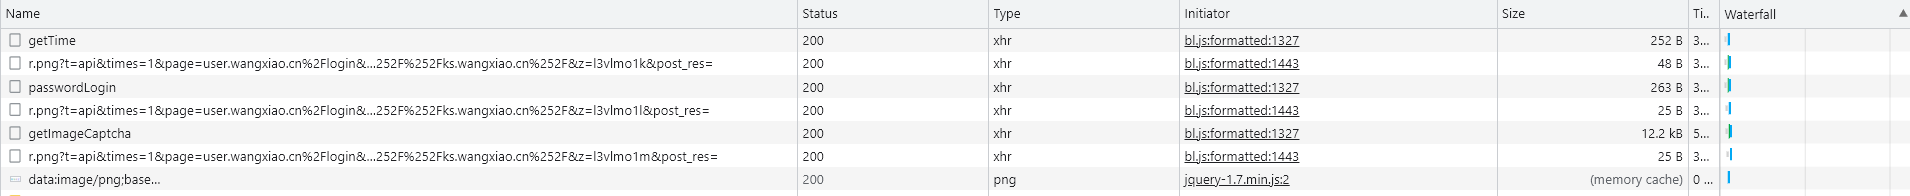

### https://user.wangxiao.cn/apis//common/getTime

向服务器发送了POST请求
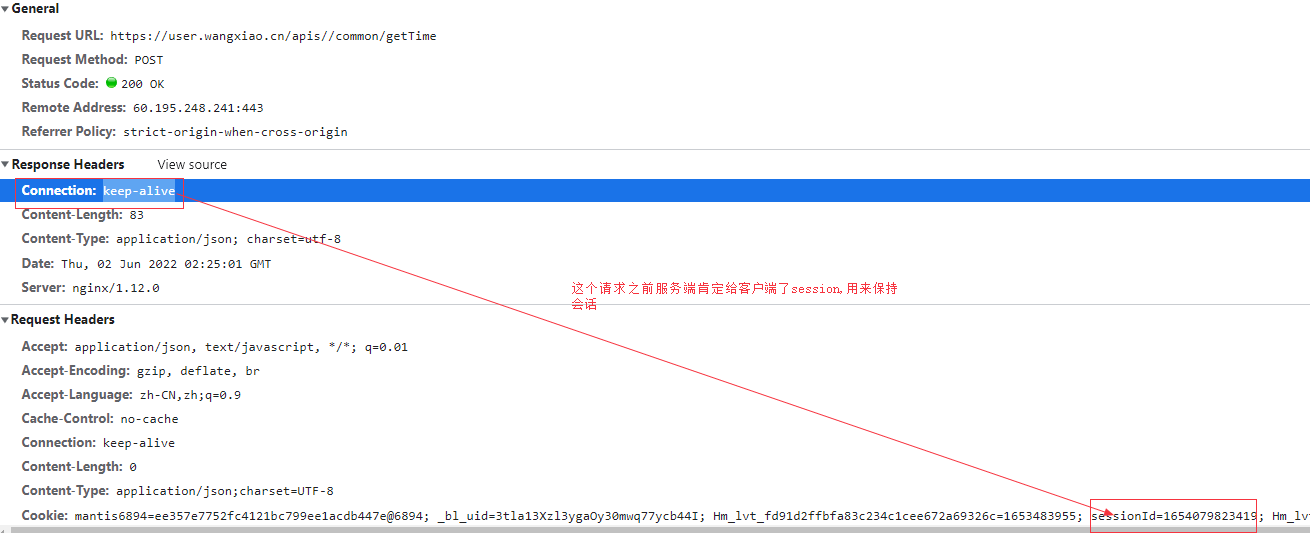

响应结果是：
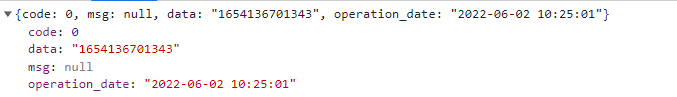

没有看到有用的信息，先不管这个url的作用。

### https://arms-retcode.aliyuncs.com/r.png?t=api&times=1&page=user.wangxiao.cn%2Flogin&tag=&release=&environment=prod&begin=1654136700681&api=%2Fapis%2F%2Fcommon%2FgetTime&success=1&time=36&code=200&msg=&traceId=91eabd571654136700681101181d1d&pv_id=yelF434mvq0lImmq7ozv1n7699Cd&domain=user.wangxiao.cn&flag=1&sr=1920x1080&vp=1920x937&ct=4g&uid=3tla13Xzl3ygaOy30mwq77ycb44I&sid=tylse3kdv2kg1wfa44d0874bs5qv&pid=ihuy5j2ab7%407cd9bc63da81d1d&_v=1.8.30&sampling=1&dl=https%3A%2F%2Fuser.wangxiao.cn%2Flogin%3Furl%3Dhttp%253A%252F%252Fks.wangxiao.cn%252F&z=l3vlmo1k&post_res=

向服务器发送post请求，携带了很多看不懂的参数，但是返回了一个没有任何内容的图片
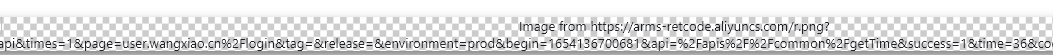

看到这种请求一定要特别注意，因为发送了这么多请求，却返回了一个什么用都没有的图片，很让人费解，一般这个是给服务器传递一些参数，让你做一些事情。

可以看到后面多个请求都是这种的，其实是在记录日志。

### https://user.wangxiao.cn/apis//login/passwordLogin

向服务器发送post请求，根据请求名字和参数，可以知道这是想服务器发送账户密码进行登录
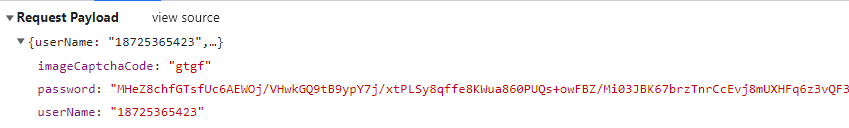

不过密码进行了加密，所以我们要对其进行逆向，分析出密码加密的逻辑

### https://user.wangxiao.cn/apis//common/getImageCaptcha

从服务端获取下一次登录验证码图片，上一次的验证码图片是在访问这个登录网站时会获取到。

## 根据抓包的网络请求分析登录逻辑

1. 拿到验证码图片
2. 识别并填写验证码
3. 对密码进行加密，登录

## 分析js的登录流程

找到发送登录请求的js代码：
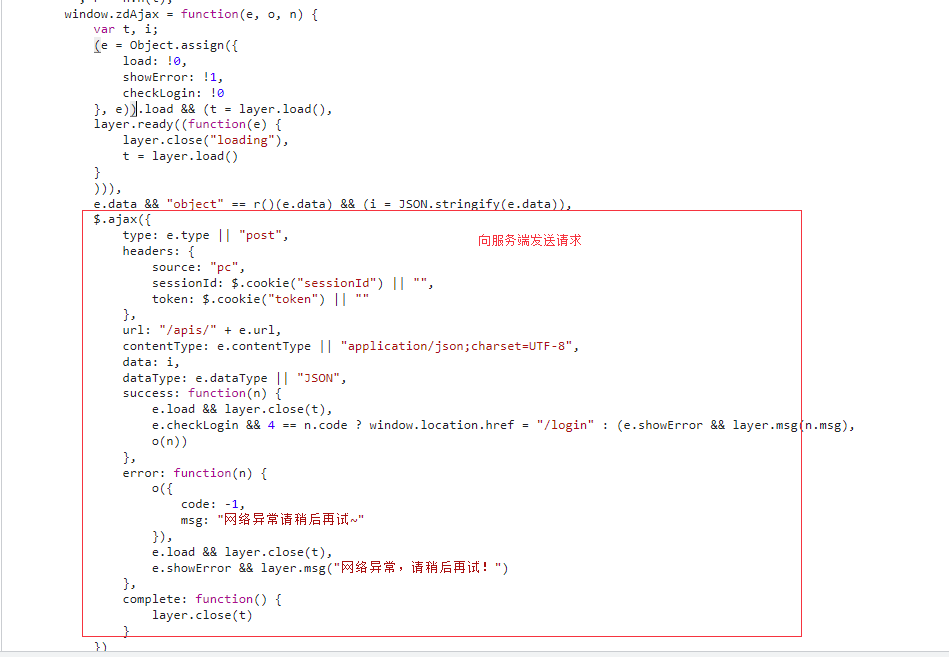

分析这段js代码：

结合上一级调用栈来看传入的参数
![image.png](attachment:image.png)
所以` window.zdAjax = function(e, o, n)`这个函数的第一个参数是个对象，第二个参数是个函数对象，第三个参数没有传递，是个undefine
```js
window.zdAjax = function(e, o, n) {
    var t, i;
    (e = Object.assign({
        load: !0,
        showError: !1,
        checkLogin: !0
    }, e)).load && (t = layer.load(),
    layer.ready((function(e) {
        layer.close("loading"),
        t = layer.load()
    }
    ))),
    e.data && "object" == r()(e.data) && (i = JSON.stringify(e.data)),  // 1. e中放的是请求的各种参数
    $.ajax({
        type: e.type || "post",
        headers: {
            source: "pc",
            sessionId: $.cookie("sessionId") || "",
            token: $.cookie("token") || ""
        },
        url: "/apis/" + e.url,
        contentType: e.contentType || "application/json;charset=UTF-8",
        data: i,
        dataType: e.dataType || "JSON",
        success: function(n) {  // 2. 请求成功返回时执行的代码
            e.load && layer.close(t),
            e.checkLogin && 4 == n.code ? window.location.href = "/login" : (e.showError && layer.msg(n.msg),
            o(n))  // 3.最后调用了o,就是第二个参数传递过来的函数对象，加括号调用，参数是从服务器返回的值
        },
        error: function(n) {
            o({
                code: -1,
                msg: "网络异常请稍后再试~"
            }),
            e.load && layer.close(t),
            e.showError && layer.msg("网络异常，请稍后再试！")
        },
        complete: function() {
            layer.close(t)
        }
    })
}
```

打断点调试

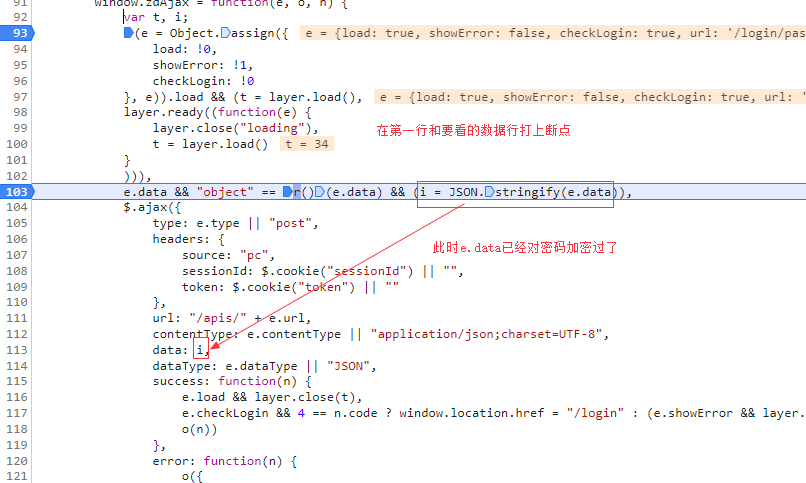

重新发送请求

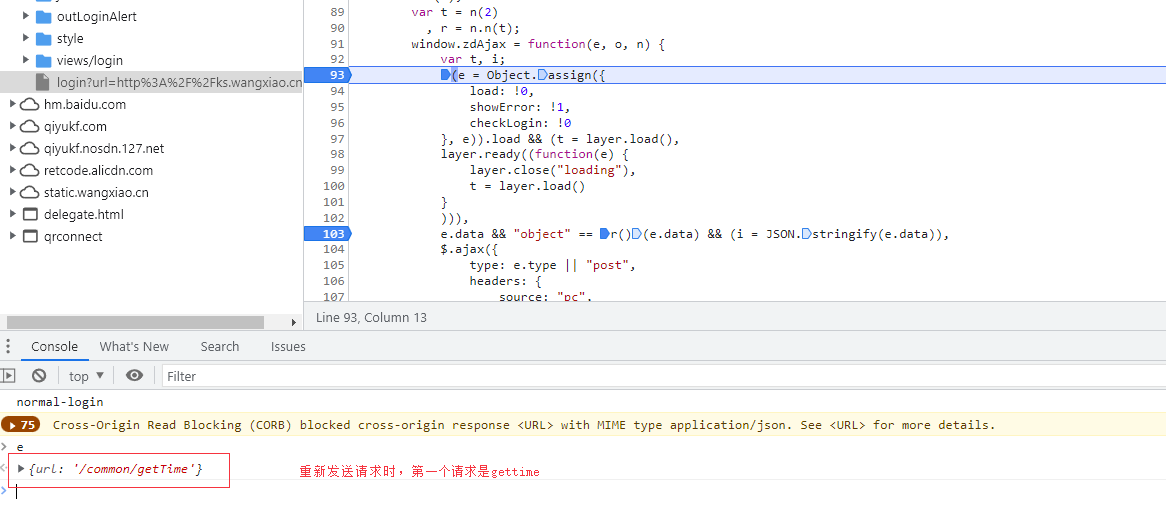

当请求回来时，执行o这个函数，在函数中根据第二个参数又发送了一次请求，这次是登录的请求，但是其用到了上一个请求返回的内容
```js
zdAjax(paramss,ress=>{  // 发送getTime请求
            var param = {
                url: '/login/passwordLogin',
                data: {
                    userName: username,  // 用户名
                    password:encryptFn(pwd+''+ress.data),  // 此时将密码和上次请求回来的值的data进行拼接，对其进行加密
                    imageCaptchaCode: imgCode  // 输入的验证码
                }
            };
		// let param = {
		// 	url: '/login/passwordLogin',
		// 	data: {
		// 		userName: username,
		// 		password:encryptFn(pwd),
		// 		imageCaptchaCode: imgCode
		// 	}
		// } ;

		//去请求接口，发送登录请求，登录请求是基于getTime请求
		zdAjax(param,res=>{
			if(res.code == 0){  // 登录完成后执行的函数，在这里有对cookiede设置，request.session只能对浏览器请求头和响应头的cookie，session进行自动保存，js'代码中的cookie只能手动来增加
				if($('#auto-login').is(':checked')){
					//自动登录
					keepOurCookie12("autoLogin",true,30) ;
					keepOurCookie12("userInfo",JSON.stringify(res.data),expiresDay) ;
					keepOurCookie12("token",res.data.token,expiresDay) ;
					syncLogin(res.data,expiresDay) ;
				}else{
					keepOurCookie12("autoLogin",null) ;
					keepOurCookie12("userInfo",JSON.stringify(res.data)) ;
					keepOurCookie12("token",res.data.token) ;
					syncLogin(res.data) ;
				}

				login.jump(res.data.isBindingMobile) ;
            }else if(res.code == "9"){
                //密码错误达到了两次
                login.getImgCode($("#nimg-code .img-code-click")) ;
                $("#nimg-code").addClass("show") ;
                layer.msg(res.msg) ;
            }else{
                layer.msg(res.msg) ;
            }
		}) ;})
```

还有一个保持会话的session是什么时候来的？

打开无痕模式，访问登录首页
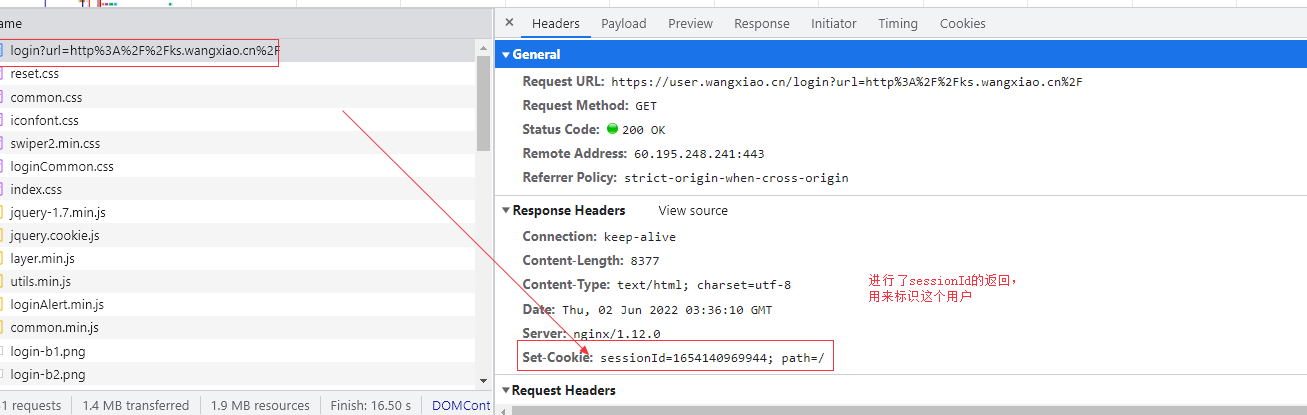

## 分析出新的登录请求顺序

1. 想办法加载一个cookie进来(目的是要sessionid) 先访问一下login页面. 目的是加载cookie(sessionid)。因为服务器端设置session信息，并将sessionId返回给客户端，后续请求会携带sessionId表明身份
2. 获取验证码图片
3. 识别验证码
4. getTime
5. 密码逆向加密，登录

## python实现

1. 要拿到最开始的sessionID，并且自动加载cookie

In [6]:
import requests

session = requests.session()
session.headers = {
    # 一般写ua
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.61 Safari/537.36",
}

resp = session.get(url='https://user.wangxiao.cn/login?url=http%3A%2F%2Fks.wangxiao.cn%2F')  # 加载原始的cookie，session
print(resp.cookies)
print(session.cookies)  # 请求头和响应头的cookie，自动加载保持

<RequestsCookieJar[<Cookie sessionId=1654162330883 for user.wangxiao.cn/>]>
<RequestsCookieJar[<Cookie sessionId=1654162330883 for user.wangxiao.cn/>]>


2. 获取验证码图片

In [7]:
image_code_url = 'https://user.wangxiao.cn/apis//common/getImageCaptcha'
image_code_resp = session.post(url=image_code_url)
print(image_code_resp.text)

<!DOCTYPE html><html><head><meta charset="utf-8">
<meta http-equiv="X-UA-Compatible" content="IE=Edge,chrome=1">
<meta name="renderer" content="webkit"><title>中大网校</title><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"><meta name="keywords" content="中大网校网络课程，网校选课中心，网络学院，中大网校"><meta name="description" content="中大网校课程中心为广大考生提供工程类，财会类，资格类，外语类，医药类等考试的课程辅导"><meta http-equiv="x-dns-prefetch-control" content="on"><link rel="dns-prefetch" href="//static.wangxiao.cn"><link rel="preconnect" href="//img.wangxiao.cn"><link rel="stylesheet" href="//static.wangxiao.cn/user/style/reset.css"><link rel="stylesheet" href="/style/common.css"><link rel="stylesheet" href="//static.wangxiao.cn/user/iconfont/iconfont.css"><link rel="shortcut icon" href="//wap.wangxiao.cn/favicon.ico">
<link rel="icon" href="//wap.wangxiao.cn/favicon.ico"><link rel="stylesheet" href="/views/404/index.css"></head><body><script>!(function(c,b,d,a){c[a]||(c[a]={});c[a].config={pid:"ihuy5j2ab

发现返回的数据不是我们想要的数据，返回的是一堆html，这个时候要特别注意，可能存在下面的情况：
- 请求头不对，可以将所有请求头加上一个一个试。
- ip或者账号被服务器干掉了，这只能加代理或换ip了。

分析这个请求是post请求的请求头：
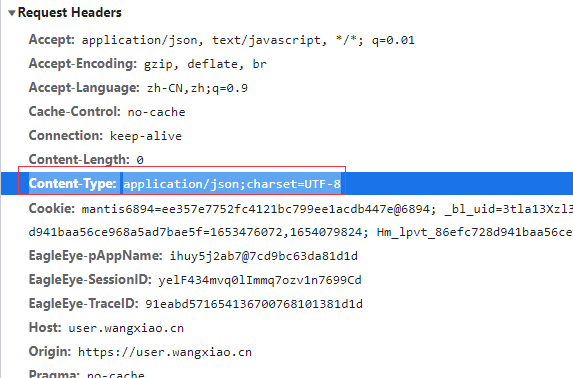

可以看出，这个请求发送的是post请求，参数json的数据格式，所以在请求时，我们要在请求头中指定这一项

{"code":0,"msg":null,"data":"","operation_date":"2022-06-02 17:32:23"}

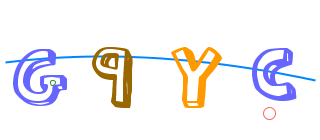

In [8]:
"""
特别注意，不能将Content-type加载session初始化请求头的地方，因为加了之后，后续所有的请求都会指定该选项，服务器收到数据和，会使用
json的方式来解析数据，所以加了之后要保证后面的请求都是以这种方式发送请求
"""
# 更新请求头内容
session.headers['Content-Type'] = 'application/json;charset=UTF-8'
image_code_resp = session.post(url=image_code_url)
print(image_code_resp.text)  # 成功拿到了验证码图片数据

# 可以看到数据在data中，是以base64编码成字符串之后，进行的网络传输。

3. 识别验证码

使用图鉴来识别

In [10]:
# 处理图片数据
import base64
import json
img_data = image_code_resp.json()['data']
img_data = img_data.split(',')[-1]


def base64_api(uname, pwd, img_b64, typeid):
    data = {"username": uname, "password": pwd, "typeid": typeid, "image": img_b64}
    result = json.loads(requests.post("http://api.ttshitu.com/predict", json=data).text)
    if result['success']:
        return result["data"]["result"]
    else:
        return result["message"]
# 识别验证码
verify_code = base64_api("nide", "nide", img_data, 3)
print(verify_code)

g9yc


4. getTime

In [12]:
get_time_url = 'https://user.wangxiao.cn/apis//common/getTime'
get_time_resp = session.post(url=get_time_url)
print(get_time_resp.text)
get_time_data = get_time_resp.json()['data']
print(get_time_data)

{"code":0,"msg":null,"data":"1654162722007","operation_date":"2022-06-02 17:38:42"}
1654162722007


5. 登录逆向

登录时，js对密码进行了逆向，所以要看逆向的代码
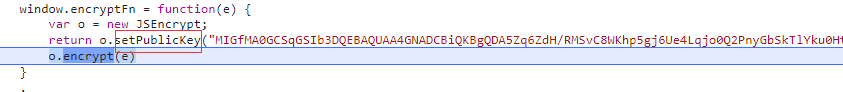
看到这个setPublickey，就可以知道这是一个非对称加密，后续不用看了，我们知道了加密方式和公钥，直接上python

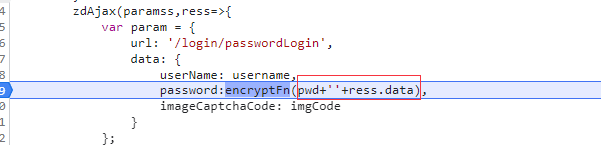
密码加密的参数是，getTime返回值的data和密码拼接之后的结果，所以之前的getTime请求有大用处

In [13]:
import base64
# 仔细看，网页上的public key是通过base64编码之后的
public_key = "MIGfMA0GCSqGSIb3DQEBAQUAA4GNADCBiQKBgQDA5Zq6ZdH/RMSvC8WKhp5gj6Ue4Lqjo0Q2PnyGbSkTlYku0HtVzbh3S9F9oHbxeO55E8tEEQ5wj/+52VMLavcuwkDypG66N6c1z0Fo2HgxV3e0tqt1wyNtmbwg7ruIYmFM+dErIpTiLRDvOy+0vgPcBVDfSUHwUSgUtIkyC47UNQIDAQAB"

# 进行密码加密
from Crypto.Cipher import PKCS1_v1_5
from Crypto.PublicKey import RSA

rsa_public_key = base64.b64decode(public_key)
rsa_public_key = RSA.import_key(rsa_public_key)
print(rsa_public_key)
pwd = '123456' + str(get_time_data)
pk_rsa = PKCS1_v1_5.new(rsa_public_key)
mi = pk_rsa.encrypt(pwd.encode('utf-8'))
mi_bs64 = base64.b64encode(mi).decode()
print(mi_bs64)


Public RSA key at 0x23E048CCB20
abn7z0pl9rNOM0MCGQgxbvSnFPpjizWz44kIEZ1Vvzib6Kc7zIJWGy2K7fRgCXOw0biRVKYanKPHYeQAhDRyl51OAS9b6S+GvgXhwvNNkPqlk3tenHJfmQ2edIc0KlnIBBlqSc+UfwNWQ9vglEjeEMYINbsHAIjVNvHL0rDY9xU=


组合代码，进行登录

```python
import requests
import base64
import json

from Crypto.Cipher import PKCS1_v1_5
from Crypto.PublicKey import RSA

def base64_api(uname, pwd, img_b64, typeid):
    data = {"username": uname, "password": pwd, "typeid": typeid, "image": img_b64}
    result = json.loads(requests.post("http://api.ttshitu.com/predict", json=data).text)
    if result['success']:
        return result["data"]["result"]
    else:
        return result["message"]

session = requests.session()
session.headers = {  # content type 不能加载这里，加在这里所有的请求都是contentype指定的值了
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.61 Safari/537.36",
}


session.get('https://user.wangxiao.cn/login?url=http%3A%2F%2Fks.wangxiao.cn%2F')


session.headers['Content-Type'] = 'application/json;charset=UTF-8'
image_code_url = 'https://user.wangxiao.cn/apis//common/getImageCaptcha'
image_code_resp = session.post(url=image_code_url)
print(image_code_resp.text)  # 成功拿到了验证码图片数据


img_data = image_code_resp.json()['data']
img_data = img_data.split(',')[-1]
# 识别验证码
verify_code = base64_api("你的", "你的", img_data, 3)

get_time_url = 'https://user.wangxiao.cn/apis//common/getTime'
get_time_resp = session.post(url=get_time_url)
print(get_time_resp.text)
get_time_data = get_time_resp.json()['data']
print(get_time_data)

# 仔细看，网页上的public key是通过base64编码之后的
public_key = "MIGfMA0GCSqGSIb3DQEBAQUAA4GNADCBiQKBgQDA5Zq6ZdH/RMSvC8WKhp5gj6Ue4Lqjo0Q2PnyGbSkTlYku0HtVzbh3S9F9oHbxeO55E8tEEQ5wj/+52VMLavcuwkDypG66N6c1z0Fo2HgxV3e0tqt1wyNtmbwg7ruIYmFM+dErIpTiLRDvOy+0vgPcBVDfSUHwUSgUtIkyC47UNQIDAQAB"

# 进行密码加密
rsa_public_key = base64.b64decode(public_key)
rsa_public_key = RSA.import_key(rsa_public_key)
print(rsa_public_key)
pwd = '密码' + str(get_time_data)
pk_rsa = PKCS1_v1_5.new(rsa_public_key)
mi = pk_rsa.encrypt(pwd.encode('utf-8'))
mi_bs64 = base64.b64encode(mi).decode()
print(mi_bs64)

login_data = {
    "imageCaptchaCode": verify_code,
    "password": mi_bs64,
    "userName": "账号"
}

login_url = 'https://user.wangxiao.cn/apis//login/passwordLogin'
login_resp =session.post(url=login_url,data=json.dumps(login_data))

print(login_resp.text)
```

可以看到我们登录是成功了
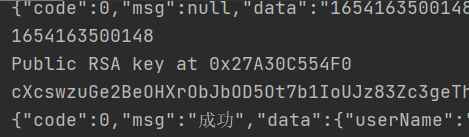

# 登录成功之后做点事情

拿到题目的链接是要登录的`http://ks.wangxiao.cn/practice/listQuestions`

In [ ]:
question_data={
    "examPointType": "",
    "practiceType": "2",
    "questionType": "",
    "sign": "jz1",
    "subsign": "8cc80ffb9a4a5c114953",
    "top": "30",
}

question_resp = session.post(url='http://ks.wangxiao.cn/practice/listQuestions', data=json.dumps(question_data))
print(question_resp.text)

我们又拿到了一段html返回值，说明我们的请求头又出现了问题

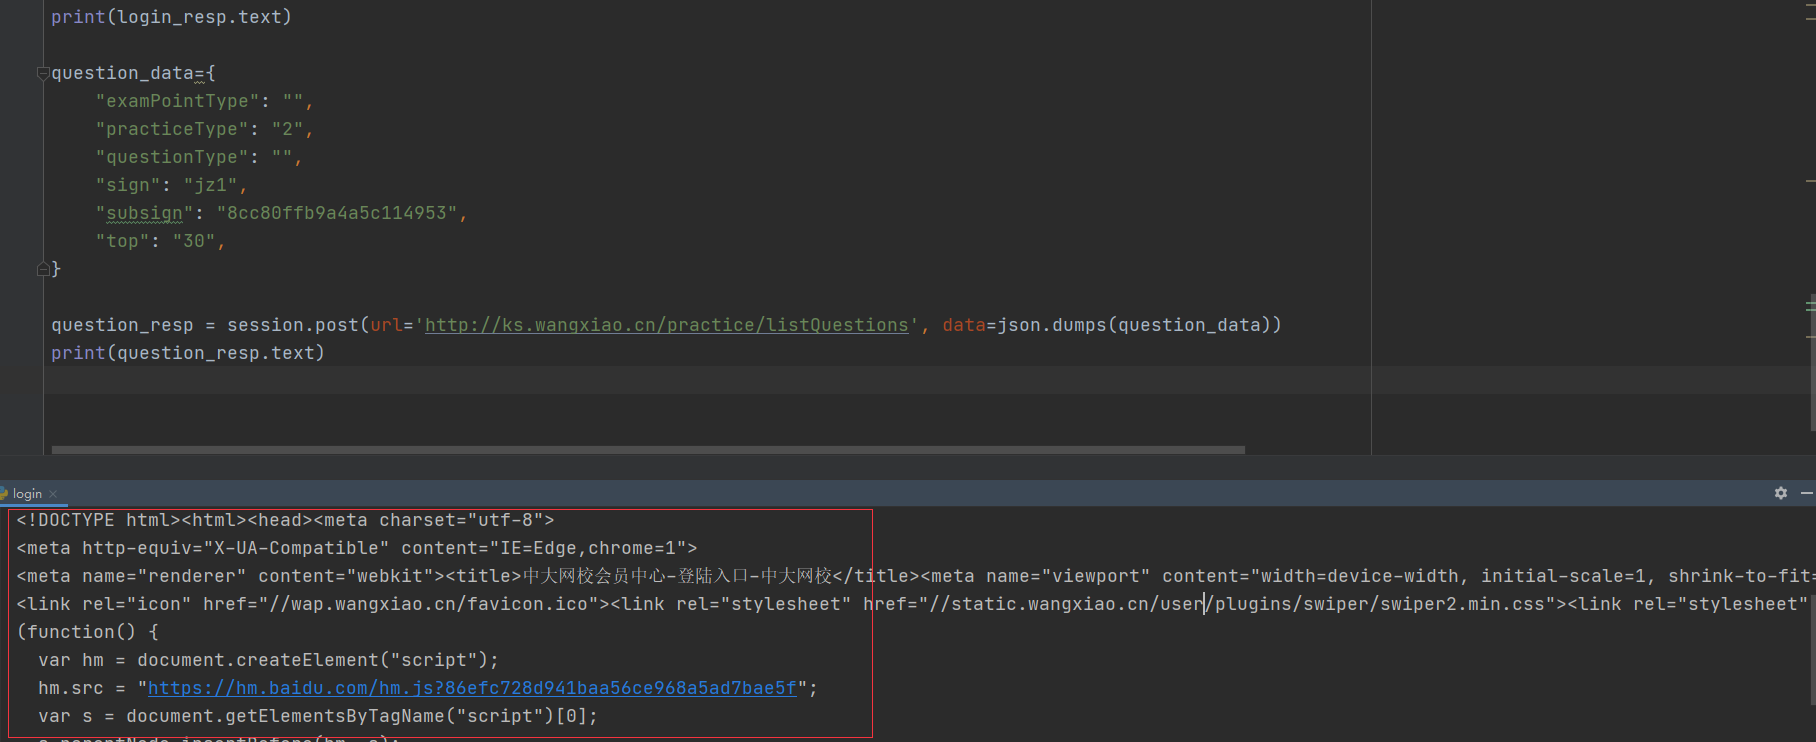

对比一下我们当前的请求头和浏览器中的请求头

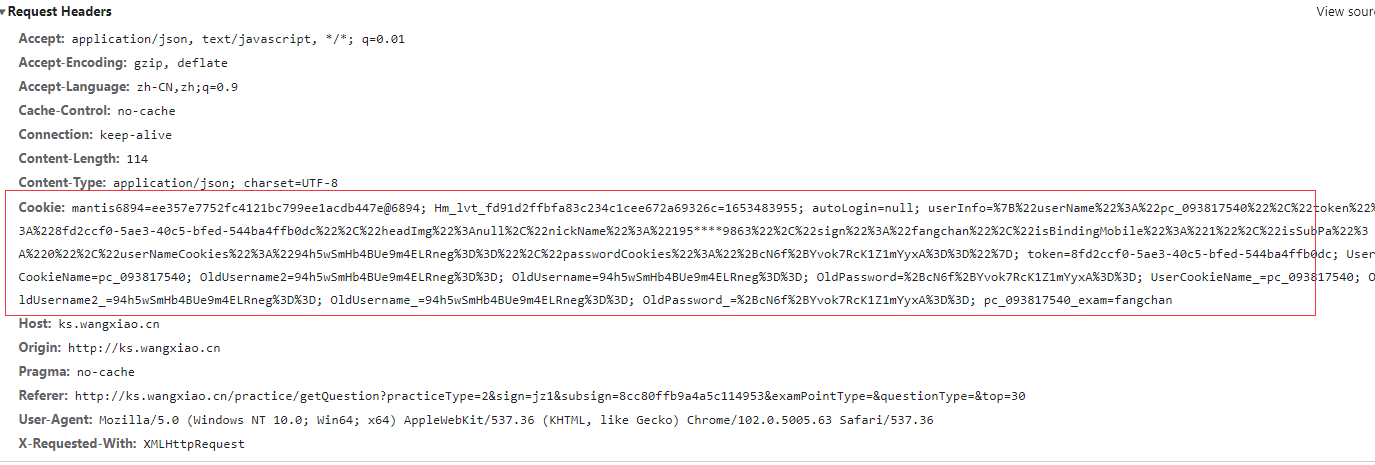

我们的cookie中只有sessionId，和浏览器差了十万八千里。请求头中的cookies一般保持会话都会自动维护，但是js生成的cookie就不能自动维护了，需要我们手动去添加

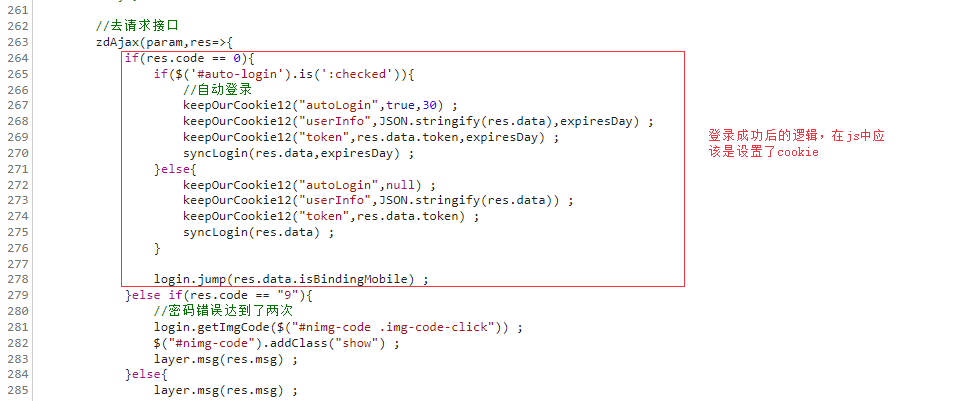

## 分析cookies设置的代码

keepOurCookie12的具体实现代码
```js
function l(e, n, t) {
    var o = {  // 创建一个对象
        path: "/",
        domain: "wangxiao.cn"
    };
    t && (o.expires = t),  // 设置到期事件，没有传递第三个参数，所以不管
    $.cookie(e, n, o)  // 设置cookie，e是key， n是 value， o是可选参数，里面有到期时间和其他类型，解决跨域等问题，可以自行查看其用法
}
```

syncLogin的具体代码
```js
window.syncLogin = function(e, o) {  // 只传递了一个参数e,e是登录成功之后返回的json中的data内容
    var n = {
        path: "/",
        domain: "wangxiao.cn"
    };
    o && (n.expires = o),  // o 存在设置过期时间
    $.cookie("UserCookieName", e.userName, n),  // 下面都是设置cookie
    $.cookie("OldUsername2", e.userNameCookies, n),
    $.cookie("OldUsername", e.userNameCookies, n),
    $.cookie("OldPassword", e.passwordCookies, n),
    $.cookie("UserCookieName_", e.userName, n),
    $.cookie("OldUsername2_", e.userNameCookies, n),
    $.cookie("OldUsername_", e.userNameCookies, n),
    $.cookie("OldPassword_", e.passwordCookies, n),
    e.sign && (n.expires = 365,
    $.cookie(e.userName + "_exam", e.sign, n))
}
```

python设置cookie
```python
'''
keepOurCookie12("autoLogin",null) ;
    keepOurCookie12("userInfo",JSON.stringify(res.data)) ;
    keepOurCookie12("token",res.data.token) ;
    syncLogin(res.data) ;

$.cookie("UserCookieName", e.userName, n),
$.cookie("OldUsername2", e.userNameCookies, n),
$.cookie("OldUsername", e.userNameCookies, n),
$.cookie("OldPassword", e.passwordCookies, n),
$.cookie("UserCookieName_", e.userName, n),
$.cookie("OldUsername2_", e.userNameCookies, n),
$.cookie("OldUsername_", e.userNameCookies, n),
$.cookie("OldPassword_", e.passwordCookies, n),
e.sign && (n.expires = 365,
$.cookie(e.userName + "_exam", e.sign, n))
					
'''

# 更新cookies
session.cookies['autoLogin'] = 'null'
session.cookies['userInfo'] = json.dumps(login_resp_data)
session.cookies['token'] = login_resp_data['token']
session.cookies['UserCookieName'] = login_resp_data['userName']
session.cookies['OldUsername2'] = login_resp_data['userNameCookies']
session.cookies['OldUsername'] = login_resp_data['userNameCookies']
session.cookies['OldPassword'] = login_resp_data['passwordCookies']
session.cookies['UserCookieName_'] = login_resp_data['userName']
session.cookies['OldUsername2_'] = login_resp_data['userNameCookies']
session.cookies['OldUsername_'] = login_resp_data['userNameCookies']
session.cookies['OldPassword_'] = login_resp_data['passwordCookies']
session.cookies[login_resp_data['userName']+"_exam"] = login_resp_data['sign']

question_data={
    "examPointType": "",
    "practiceType": "2",
    "questionType": "",
    "sign": "jz1",
    "subsign": "8cc80ffb9a4a5c114953",
    "top": "30",
}

question_resp = session.post(url='http://ks.wangxiao.cn/practice/listQuestions', data=json.dumps(question_data))
print(question_resp.text)
```

拿到了具体的数据
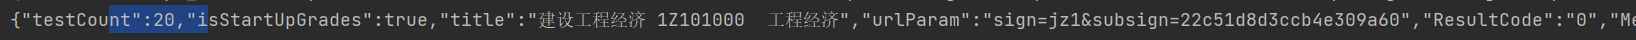